# AI Platform ML Metadata -- Sample Notebook

# Prerequisites

Please follow the "Getting Started" section of the [User Guide](https://docs.google.com/document/d/1WNEFvjZbki0GTG2oB5JS7D2JVaQjH8PUlVSTt9xPSjQ/edit?usp=sharing) to be able to use the service.

# Installation

You will need to be authenticated with gcloud as a user with valid permissions in a properly prepared project.

In [ ]:
!gcloud auth login


You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be visible to others with access to this
virtual machine. Are you sure you want to authenticate with
your personal account?

Do you want to continue (Y/n)?  

In [ ]:
!gcloud auth application-default login

Get packages and install them. You may need to restart the kernel after this step.

In [ ]:
!gsutil cp gs://cloud-aiplatform-metadata/sdk/google-cloud-aiplatform-metadata-0.0.1.tar.gz .
!pip3 install google-cloud-aiplatform-metadata-0.0.1.tar.gz
#!pip3 install tensorflow

In [ ]:
#!pip3 install networkx
!sudo apt-get -y install graphviz libgraphviz-dev pkg-config
!pip3 install pygraphviz 

Ref: https://www.tensorflow.org/tutorials/keras/regression

## Steps
1. Read data
2. Clean data
3. Train test split data
4. Normalize data
5. Train
6. Evaluate

In [32]:
import pathlib
import numpy as np
import pandas as pd
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.utils import data_utils
from google.cloud import aiplatform

aiplatform.connect(project='rthallam-demo-project', location='us-central1')
aiplatform.set_experiment('automobile-fuel-economy-prediction')

In [14]:
@aiplatform.execution(name="Data Reader")
def read_data(uri):
    aiplatform.log_parameter('data uri', uri)
    dataset_path = data_utils.get_file("auto-mpg.data", uri)
    column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                    'Acceleration', 'Model Year', 'Origin']
    raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?",
                              comment='\t', sep=" ", skipinitialspace=True)
    
    aiplatform.log_dataset(raw_dataset, "Raw Auto MPG Data")
    return raw_dataset

dataset = read_data("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

INFO:root:Logging "Data Reader" execution 
resource_name: projects/560224572293/locations/us-central1/metadataStores/default/executions/a79af4b8-a8d6-467e-86d3-c698f5f45af4


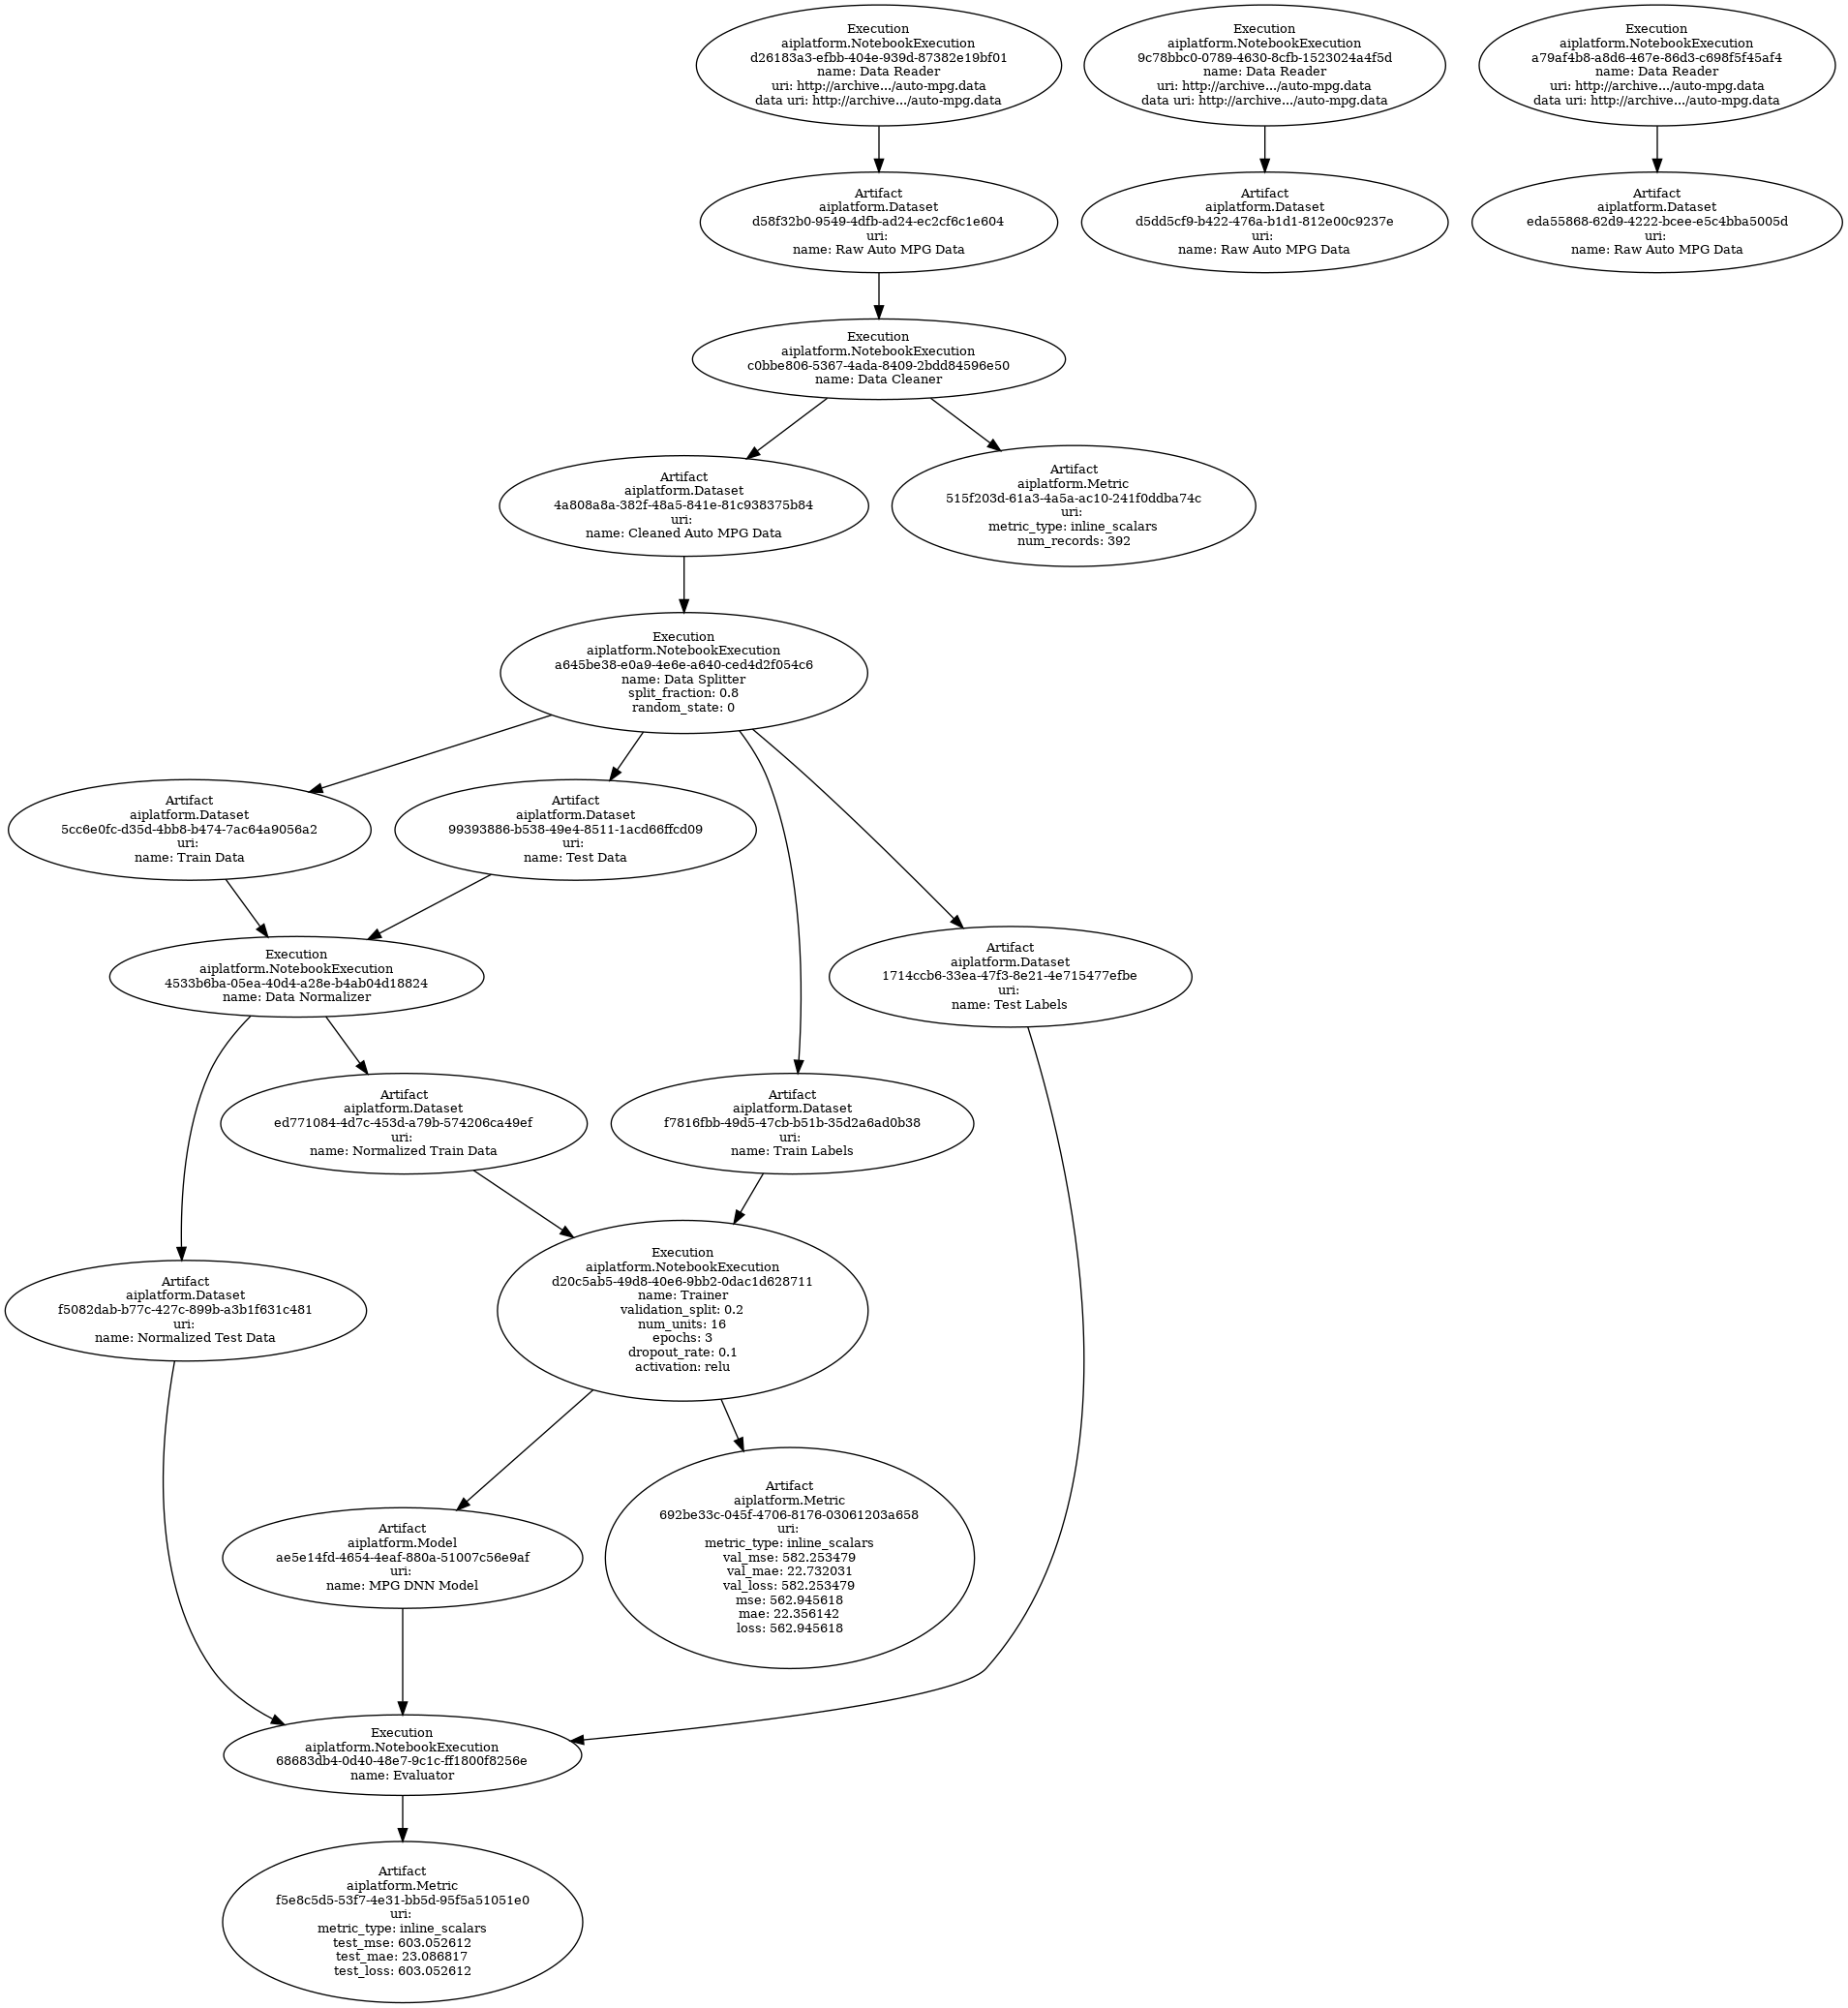

In [15]:
aiplatform.graph_experiment()

In [16]:
@aiplatform.execution(name="Data Cleaner")
def clean_data(dataset):
    dataset = dataset.dropna()
    dataset['Origin'] = dataset['Origin'].map(
        lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
    dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')        
    aiplatform.log_dataset(dataset, "Cleaned Auto MPG Data")
    aiplatform.log_metric('num_records', dataset.shape[0])
    return dataset

clean_dataset = clean_data(dataset)

INFO:root:Logging "Data Cleaner" execution 
resource_name: projects/560224572293/locations/us-central1/metadataStores/default/executions/3ce1cc85-f16d-42ba-9090-9deadd045067
Input Artifacts to resource_name: 
  dataset: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/eda55868-62d9-4222-bcee-e5c4bba5005d


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


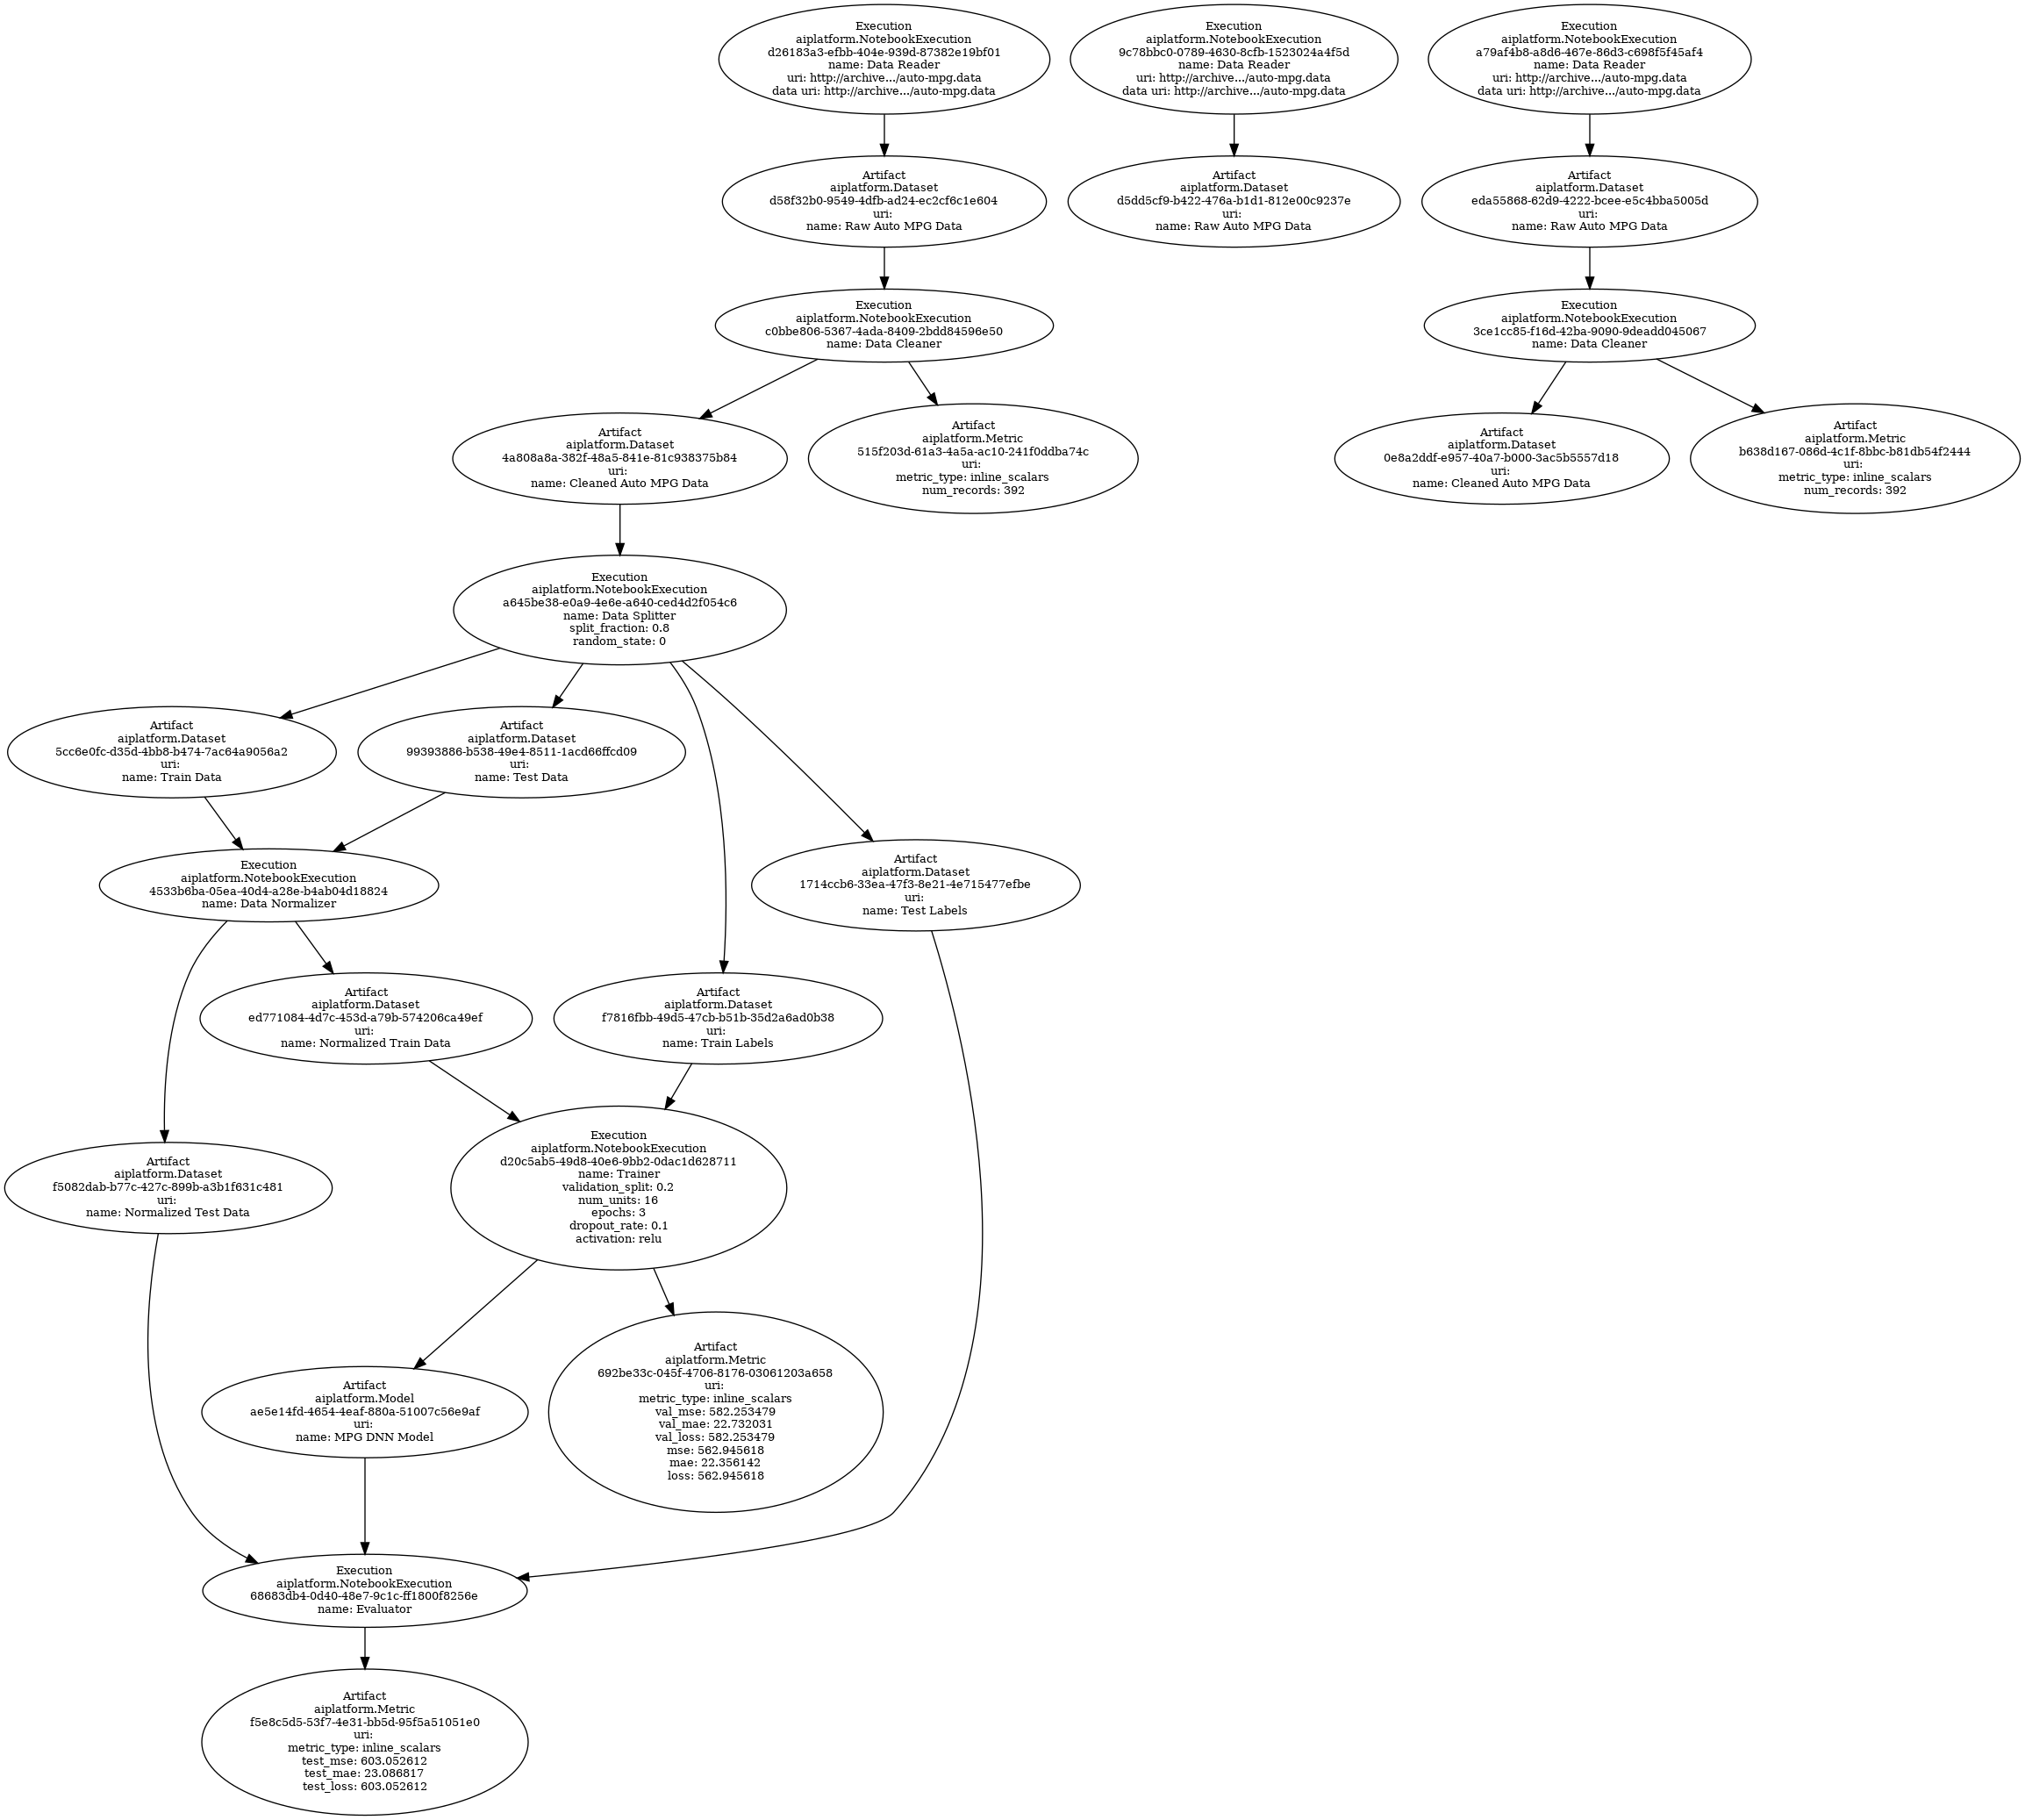

In [17]:
aiplatform.graph_experiment()

In [18]:
@aiplatform.execution(name="Data Splitter")
def train_test_split(dataset, split_frac=0.8, random_state=0):
    aiplatform.log_parameters(split_fraction=split_frac,
                            random_state=random_state)
    
    train_dataset = dataset.sample(frac=split_frac, random_state=random_state)
    test_dataset = dataset.drop(train_dataset.index)
    train_labels = train_dataset.pop('MPG')
    test_labels = test_dataset.pop('MPG')
    
    aiplatform.log_dataset(train_dataset, "Train Data")
    aiplatform.log_dataset(test_dataset, "Test Data")
    aiplatform.log_dataset(train_labels, "Train Labels")
    aiplatform.log_dataset(test_labels, "Test Labels")
    
    return train_dataset, test_dataset, train_labels, test_labels

train_dataset, test_dataset, train_labels, test_labels = train_test_split(clean_dataset)

INFO:root:Logging "Data Splitter" execution 
resource_name: projects/560224572293/locations/us-central1/metadataStores/default/executions/8daafb0c-e41c-4f8e-bdf7-ba4859893e20
Input Artifacts to resource_name: 
  dataset: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/0e8a2ddf-e957-40a7-b000-3ac5b5557d18


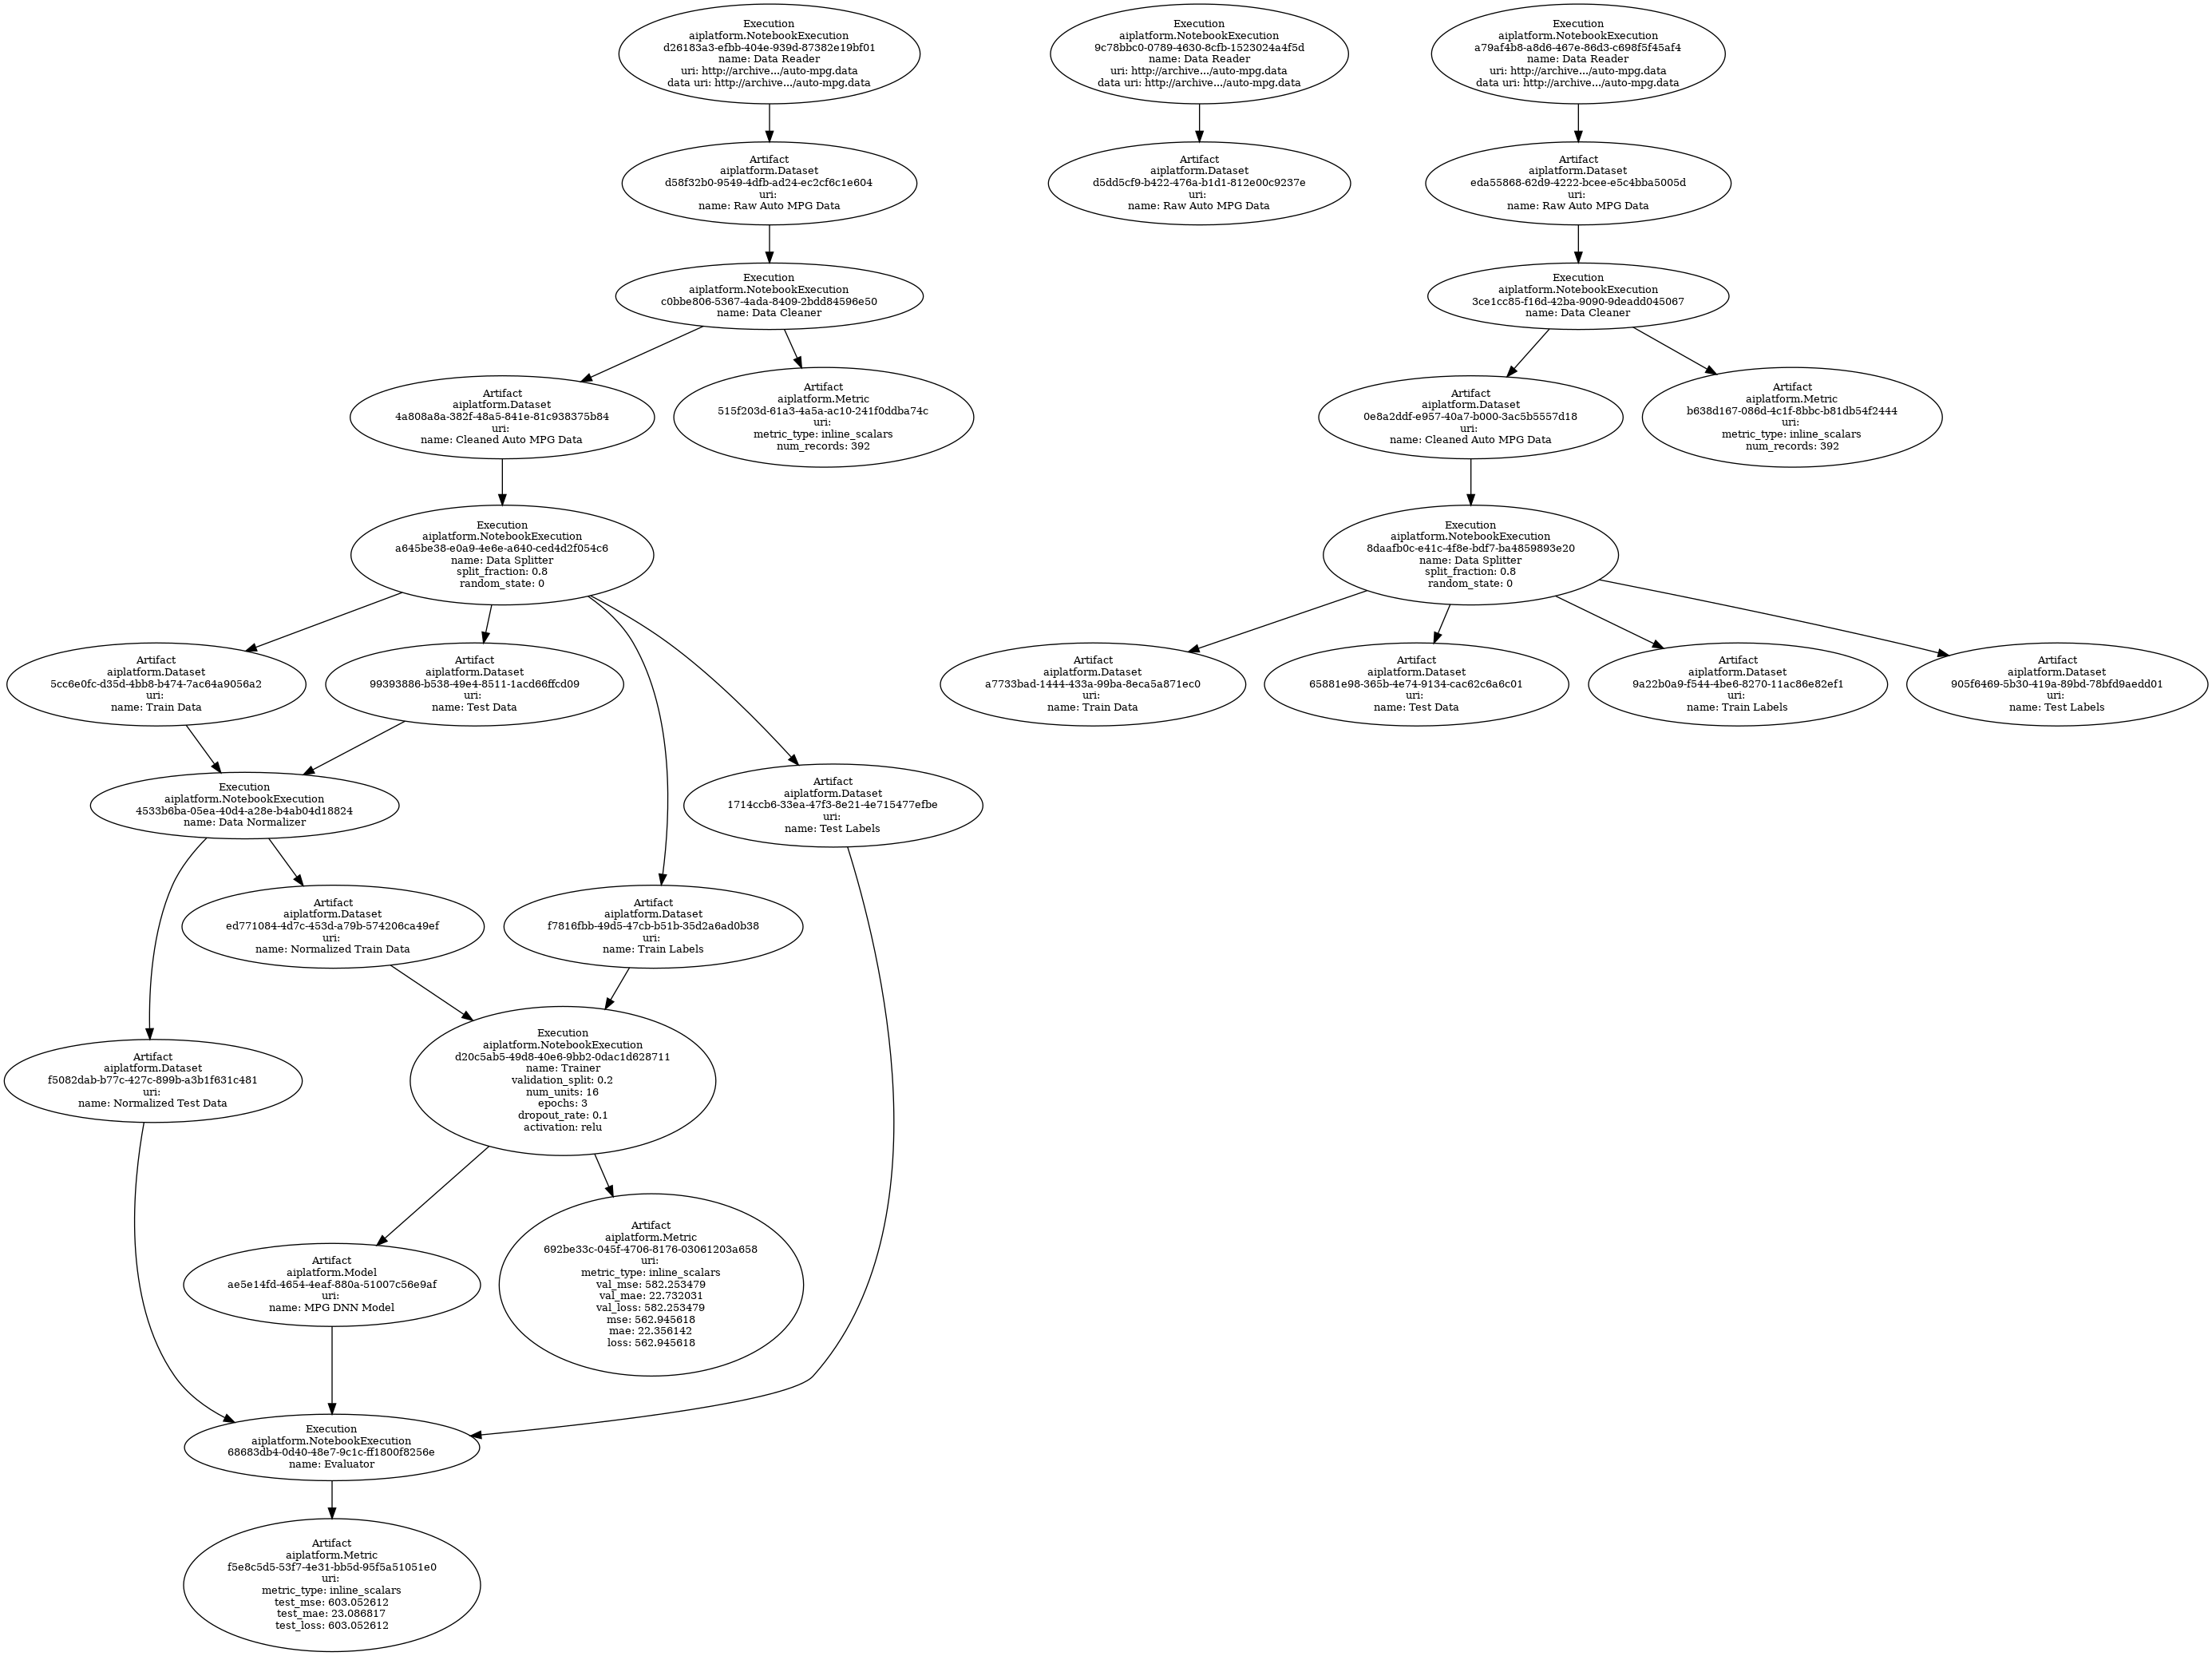

In [19]:
aiplatform.graph_experiment()

In [20]:
@aiplatform.execution(name="Data Normalizer")
def normalize_dataset(train_dataset, test_dataset):
    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose()
    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)
    aiplatform.log_dataset(normed_train_data, "Normalized Train Data")
    aiplatform.log_dataset(normed_test_data, "Normalized Test Data")
    
    return normed_train_data, normed_test_data

normed_train_data, normed_test_data = normalize_dataset(train_dataset,
                                                        test_dataset)

INFO:root:Logging "Data Normalizer" execution 
resource_name: projects/560224572293/locations/us-central1/metadataStores/default/executions/7c6e940f-53b1-47ad-a73e-f19a05acc94f
Input Artifacts to resource_name: 
  train_dataset: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/a7733bad-1444-433a-99ba-8eca5a871ec0
  test_dataset: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/65881e98-365b-4e74-9134-cac62c6a6c01


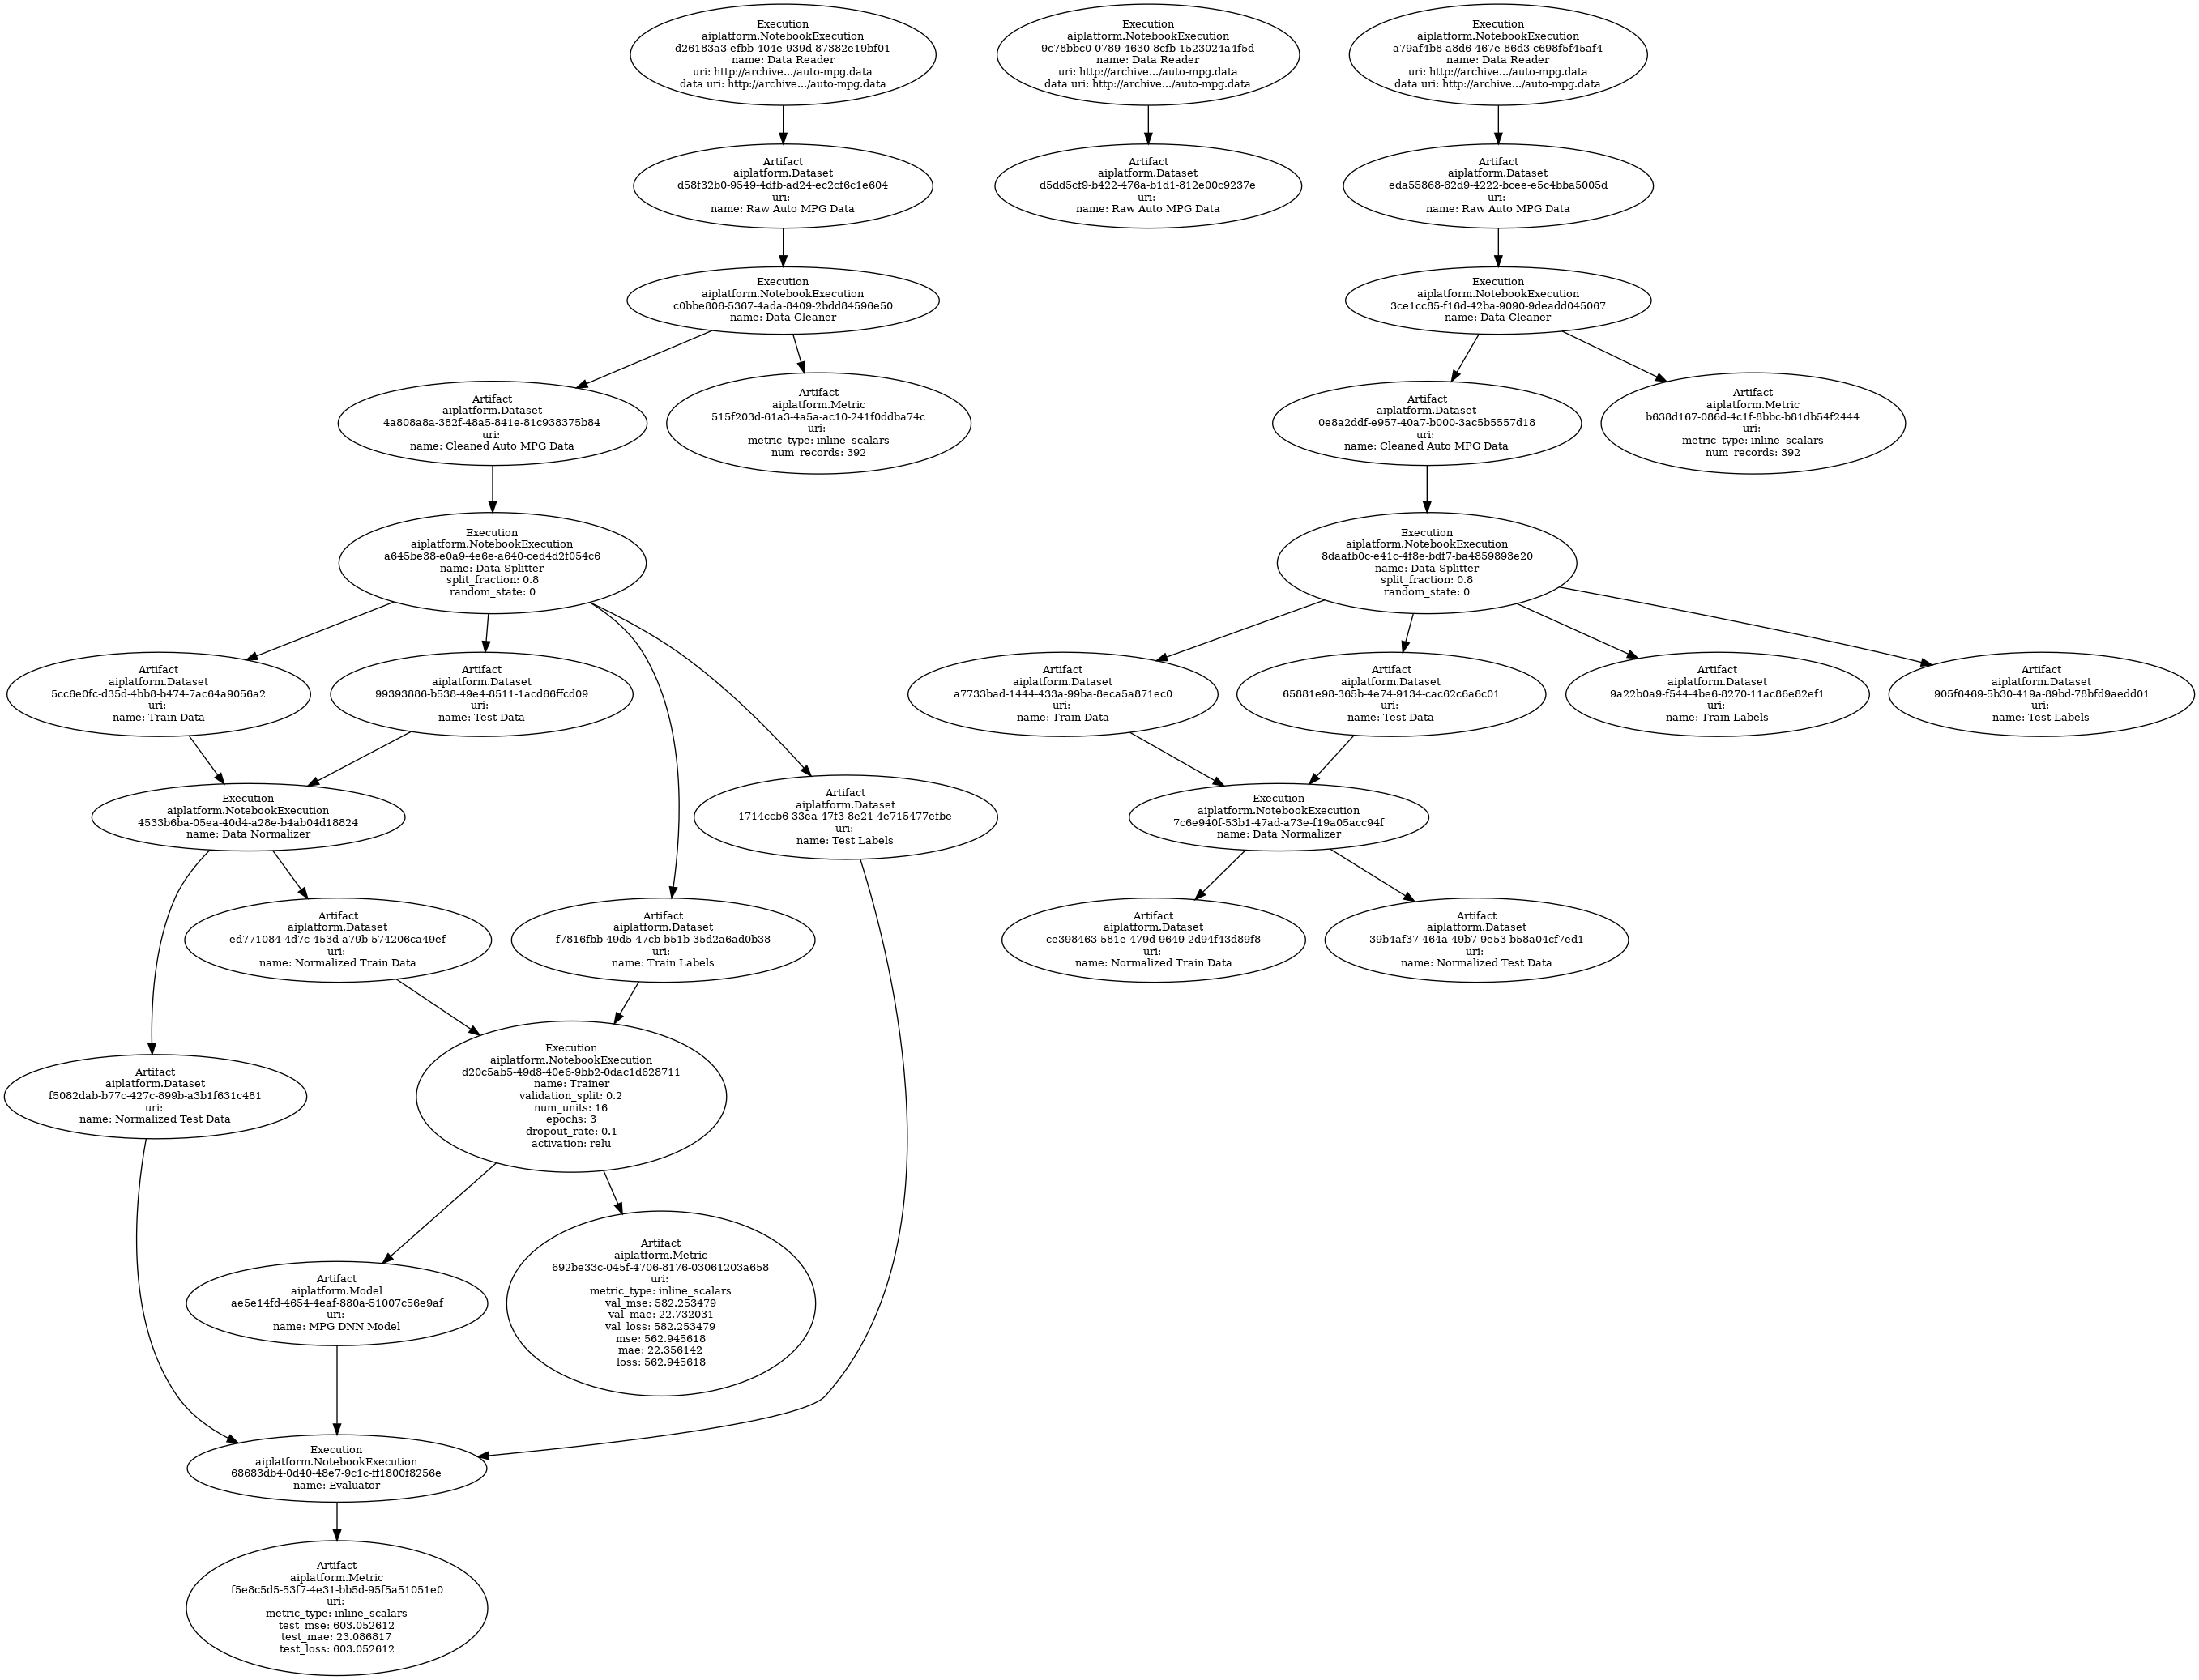

In [21]:
aiplatform.graph_experiment()

In [22]:
@aiplatform.execution(name="Trainer")
def train(train_data, train_labels, num_units=64, activation='relu',
          dropout_rate=0.0, validation_split = 0.2, epochs=1000):
    aiplatform.log_parameters(num_units=num_units, activation=activation,
                            dropout_rate=dropout_rate,
                            validation_split=validation_split, epochs=epochs)
    
    model = Sequential([
        layers.Dense(num_units, activation=activation,
                     input_shape=[len(train_dataset.keys())]),
        layers.Dropout(rate=dropout_rate),
        layers.Dense(num_units, activation=activation),
        layers.Dense(1)
    ])


    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    print(model.summary())
    
    history = model.fit(
      train_data, train_labels,
      epochs=epochs, validation_split=validation_split)
    
    aiplatform.log_model(model,'MPG DNN Model')
    aiplatform.log_metrics(**{metric: values[-1]
                            for metric, values in history.history.items()})

    return model, history

model, history = train(normed_train_data, train_labels, num_units=16,
                       activation='relu', epochs=3, dropout_rate=0.1)

INFO:root:Logging "Trainer" execution 
resource_name: projects/560224572293/locations/us-central1/metadataStores/default/executions/0d455816-fb5b-4c64-ab98-e140d64bd1b7
Input Artifacts to resource_name: 
  train_data: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/ce398463-581e-479d-9649-2d94f43d89f8
  train_labels: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/9a22b0a9-f544-4be6-8270-11ac86e82ef1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
________________________________________________________

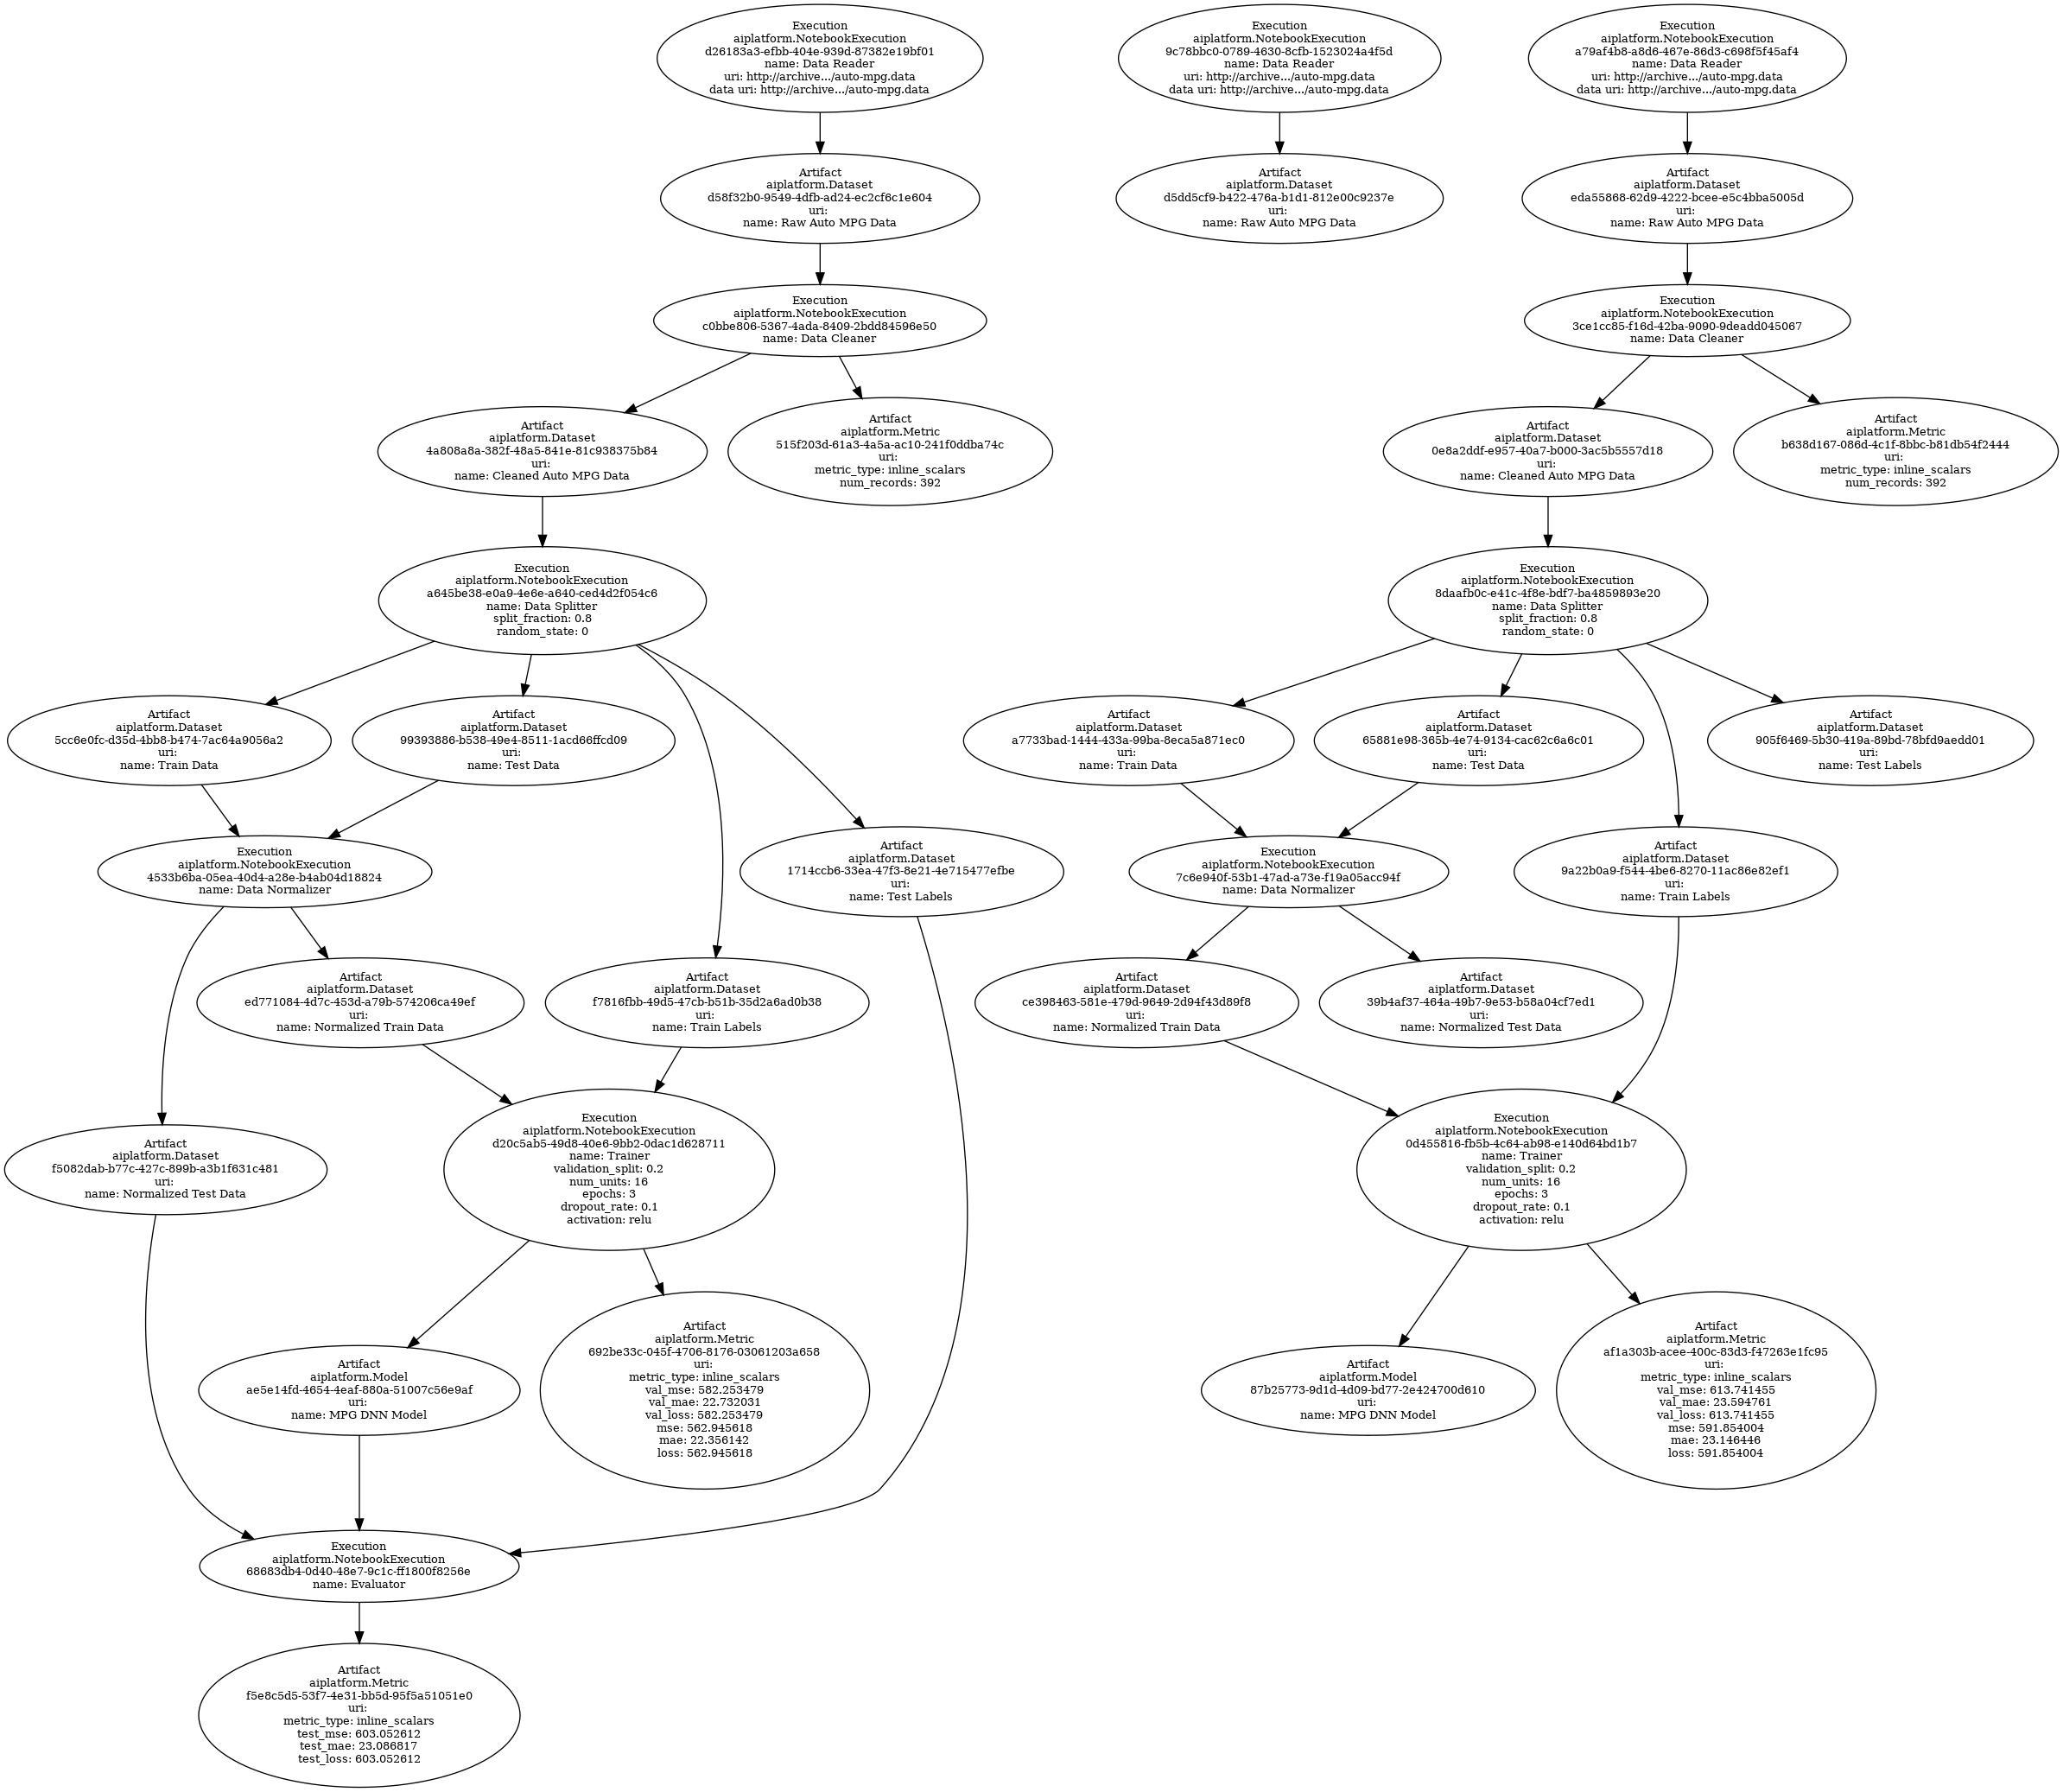

In [23]:
aiplatform.graph_experiment()

In [24]:
@aiplatform.execution(name="Evaluator")
def evaluate(model, test_data, test_labels):
    loss, mae, mse = model.evaluate(test_data, test_labels, verbose=2) 
    aiplatform.log_metrics(test_loss=loss, test_mae=mae, test_mse=mse)
    return loss, mae, mse

test_loss, test_mae, test_mse = evaluate(model, normed_test_data, test_labels)

INFO:root:Logging "Evaluator" execution 
resource_name: projects/560224572293/locations/us-central1/metadataStores/default/executions/d1a6d51f-e41e-4bf8-b646-d766aafddd78
Input Artifacts to resource_name: 
  model: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/87b25773-9d1d-4d09-bd77-2e424700d610
  test_data: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/39b4af37-464a-49b7-9e53-b58a04cf7ed1
  test_labels: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/905f6469-5b30-419a-89bd-78bfd9aedd01
3/3 - 0s - loss: 629.0191 - mae: 23.8220 - mse: 629.0191


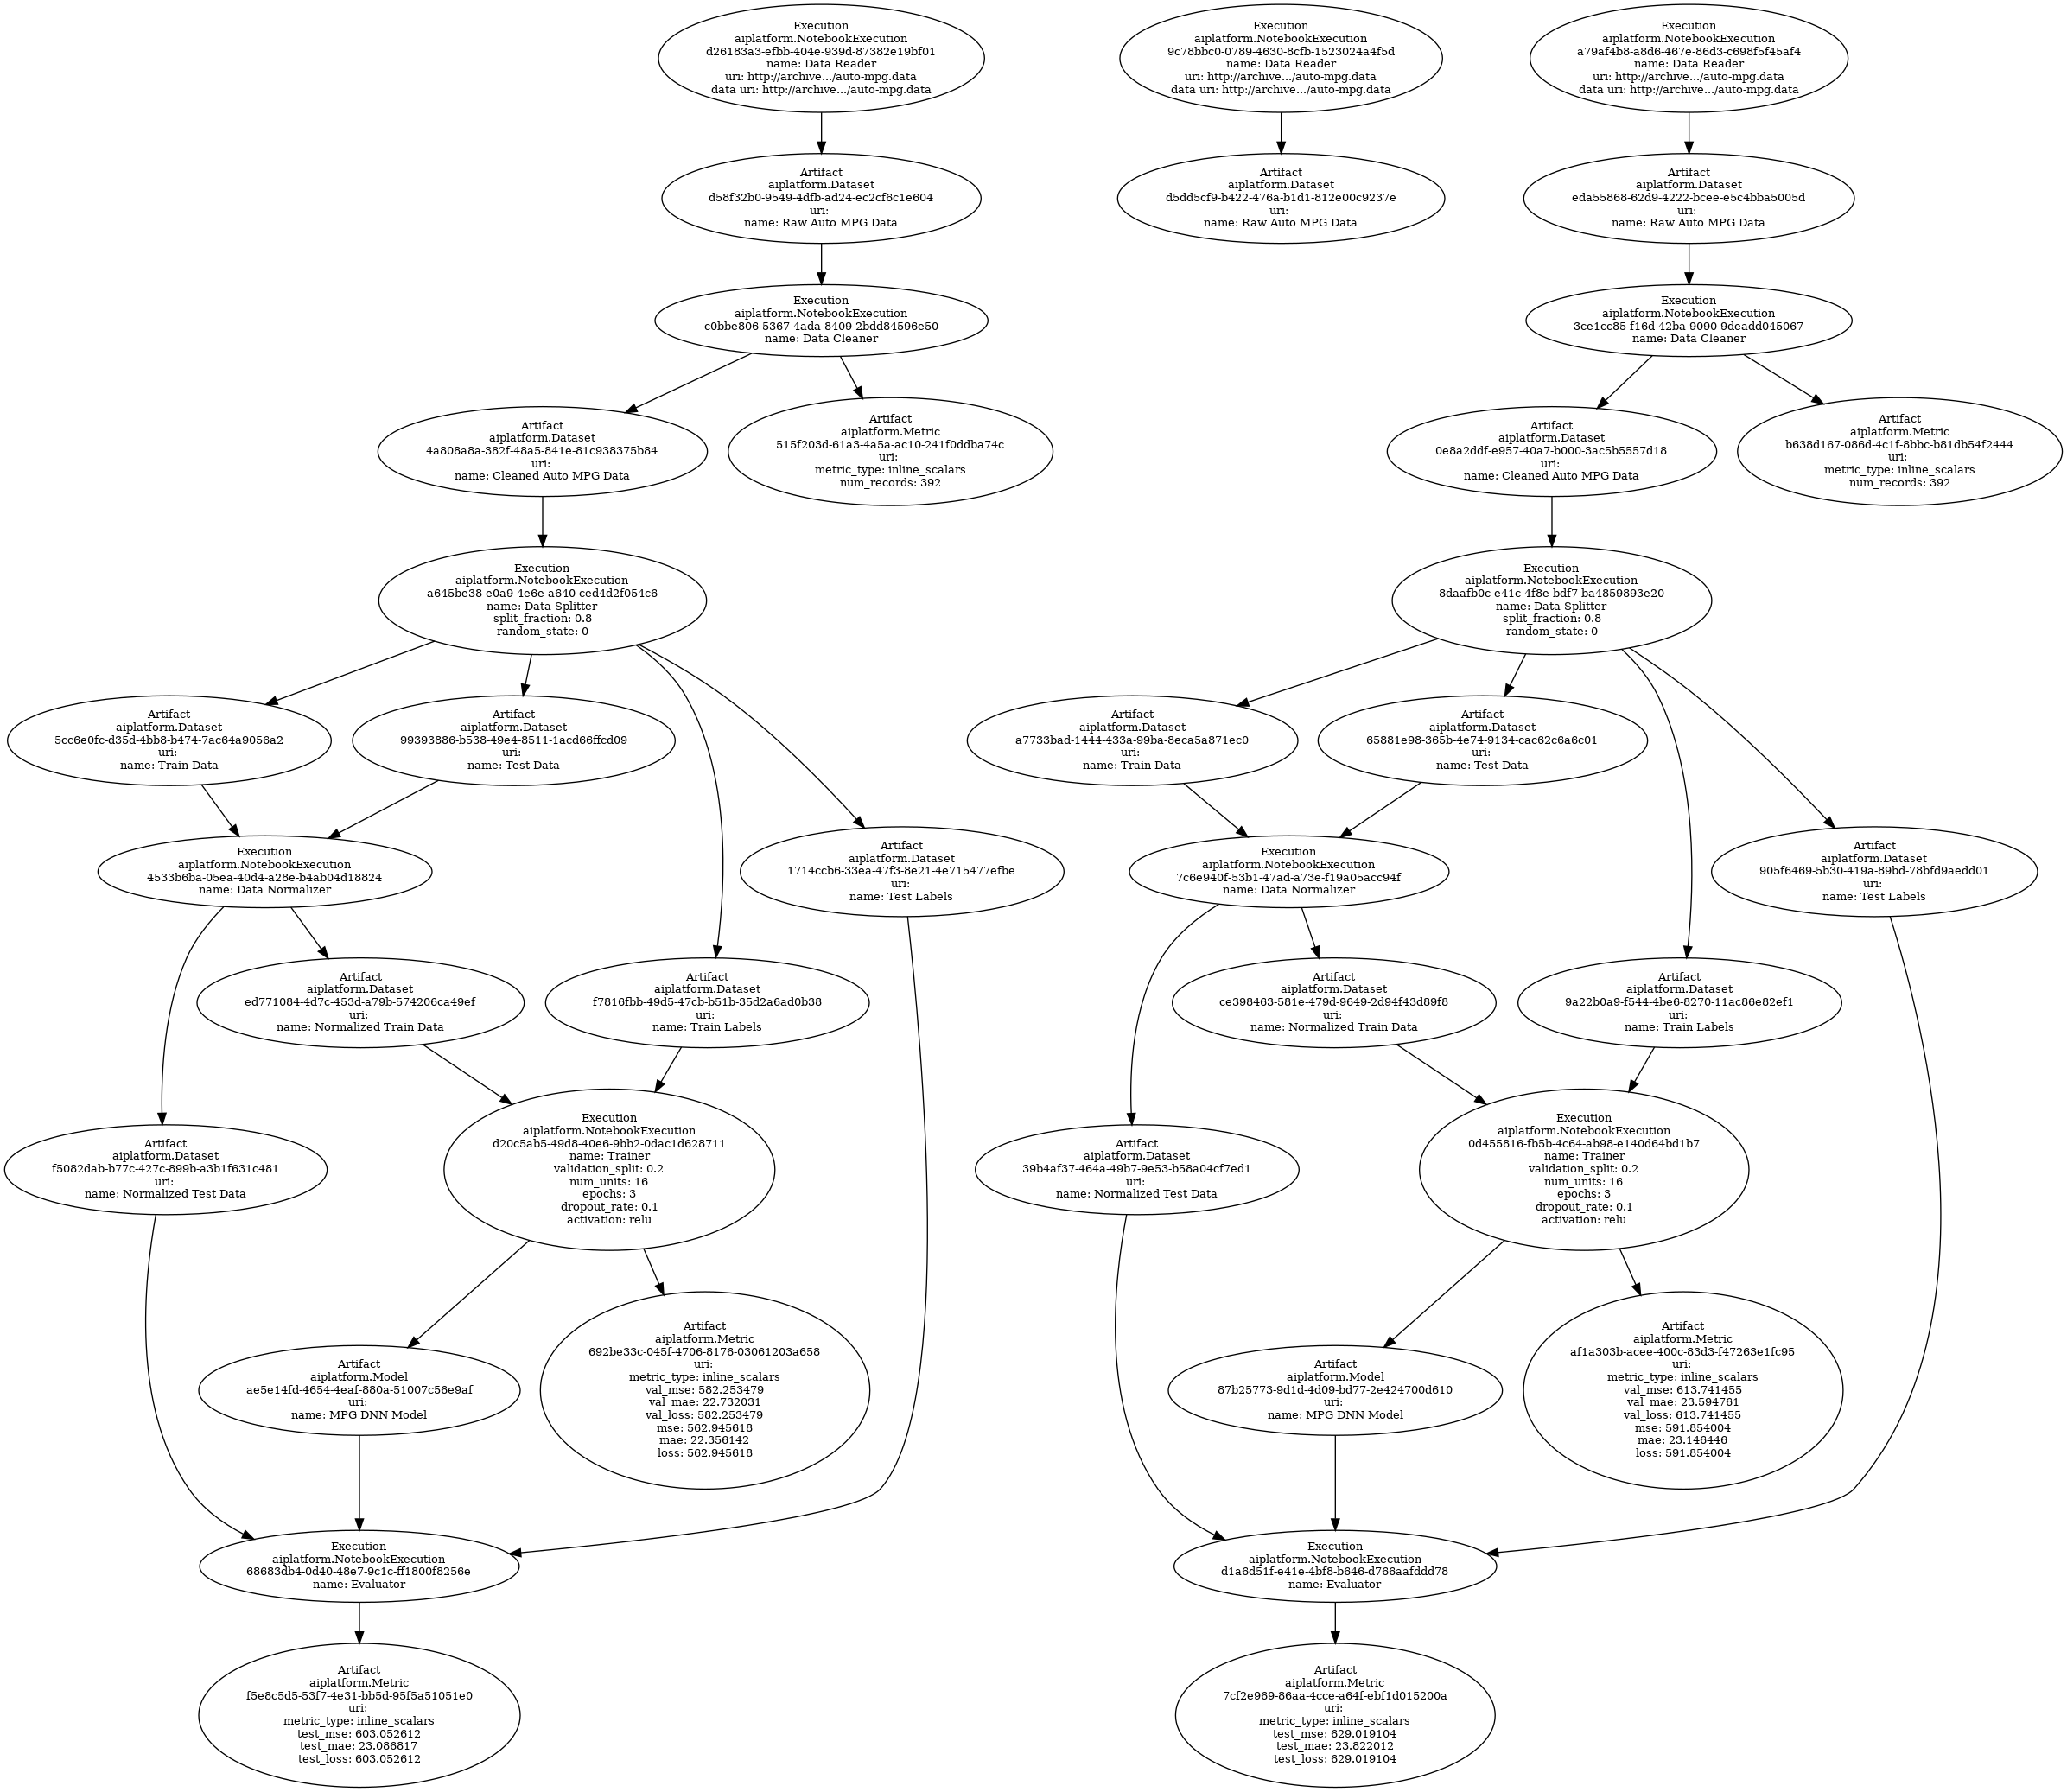

In [25]:
aiplatform.graph_experiment()

In [26]:
with aiplatform.experiment('second-experiment'):
  model, history = train(normed_train_data, train_labels, num_units=32,
                         epochs=6, dropout_rate=0.3)
  evaluate(model, normed_test_data, test_labels)

with aiplatform.experiment('third-experiment'):
  model, history = train(normed_train_data, train_labels, epochs=12)
  evaluate(model, normed_test_data, test_labels)

with aiplatform.experiment('fourth-experiment'):
  model, history = train(normed_train_data, train_labels, num_units=8,
                         epochs=12)
  evaluate(model, normed_test_data, test_labels)

INFO:root:Logging "Trainer" execution 
resource_name: projects/560224572293/locations/us-central1/metadataStores/default/executions/d0f4a1a8-a86b-4b2e-b2b5-2e8bcd2597b7
Input Artifacts to resource_name: 
  train_data: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/ce398463-581e-479d-9649-2d94f43d89f8
  train_labels: projects/560224572293/locations/us-central1/metadataStores/default/artifacts/9a22b0a9-f544-4be6-8270-11ac86e82ef1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
______________________________________________________

In [27]:
experiments_df = aiplatform.get_experiments_dataframe()

In [33]:
experiments_df

,experiment_name,experiment_resource_name,execution_name,execution_resource_name,param.dropout_rate,param.epochs,param.num_units,param.activation,param.validation_split,metric.val_mae,...,metric.val_loss,metric.loss,metric.test_mse,metric.test_mae,metric.test_loss,param.uri,param.data uri,metric.num_records,param.split_fraction,param.random_state
0,fourth-experiment,projects/560224572293/locations/us-central1/me...,Trainer,projects/560224572293/locations/us-central1/me...,0.0,12.0,8.0,relu,0.2,21.980003,...,533.179871,522.778442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fourth-experiment,projects/560224572293/locations/us-central1/me...,Evaluator,projects/560224572293/locations/us-central1/me...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,552.347961,22.353910,552.347961,NaN,NaN,NaN,NaN,NaN
2,fourth-experiment,projects/560224572293/locations/us-central1/me...,Trainer,projects/560224572293/locations/us-central1/me...,0.0,12.0,8.0,relu,0.2,23.063210,...,593.941162,569.646301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fourth-experiment,projects/560224572293/locations/us-central1/me...,Evaluator,projects/560224572293/locations/us-central1/me...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,607.664185,23.269014,607.664185,NaN,NaN,NaN,NaN,NaN
4,third-experiment,projects/560224572293/locations/us-central1/me...,Trainer,projects/560224572293/locations/us-central1/me...,0.0,12.0,64.0,relu,0.2,6.012783,...,51.685631,63.188316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,third-experiment,projects/560224572293/locations/us-central1/me...,Evaluator,projects/560224572293/locations/us-central1/me...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,44.051476,5.334333,44.051476,NaN,NaN,NaN,NaN,NaN
6,third-experiment,projects/560224572293/locations/us-central1/me...,Trainer,projects/560224572293/locations/us-central1/me...,0.0,12.0,64.0,relu,0.2,6.525954,...,61.621799,81.971367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,third-experiment,projects/560224572293/locations/us-central1/me...,Evaluator,projects/560224572293/locations/us-central1/me...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,62.713860,6.511436,62.713860,NaN,NaN,NaN,NaN,NaN
8,second-experiment,projects/560224572293/locations/us-central1/me...,Trainer,projects/560224572293/locations/us-central1/me...,0.3,6.0,32.0,relu,0.2,21.418205,...,531.391846,525.989014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,second-experiment,projects/560224572293/locations/us-central1/me...,Evaluator,projects/560224572293/locations/us-central1/me...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,552.676453,21.844460,552.676453,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='experiment_name'>

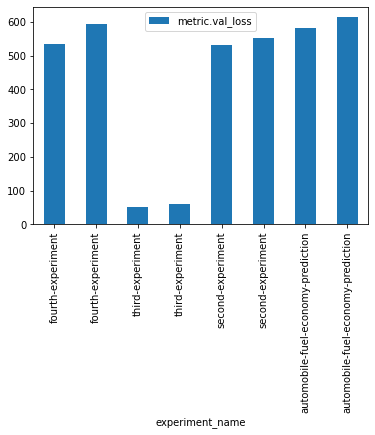

In [28]:
experiments_df.dropna(subset=['metric.val_loss']).plot.bar(x='experiment_name',
                                                           y='metric.val_loss')

In [29]:
col_names = ['experiment_name', 'param.num_units', 'param.epochs', 'metric.val_mae']
experiments_df[experiments_df.execution_name == 'Trainer'][col_names]
                                                           

,experiment_name,param.num_units,param.epochs,metric.val_mae
0,fourth-experiment,8.0,12.0,21.980003
2,fourth-experiment,8.0,12.0,23.063210
4,third-experiment,64.0,12.0,6.012783
6,third-experiment,64.0,12.0,6.525954
8,second-experiment,32.0,6.0,21.418205
10,second-experiment,32.0,6.0,22.185293
16,automobile-fuel-economy-prediction,16.0,3.0,22.732031
23,automobile-fuel-economy-prediction,16.0,3.0,23.594761


## Pivot Dataframe to view at Experiment cross section.

In [30]:
def select_first(col):
  col = col.dropna()
  if len(col):
    return col.iloc[0]

experiments_pivot = experiments_df.drop(['execution_resource_name', 'execution_name'],axis=1) \
                        .pivot_table(index='experiment_name', aggfunc=select_first)
experiments_pivot.T

experiment_name,automobile-fuel-economy-prediction,fourth-experiment,second-experiment,third-experiment
experiment_resource_name,projects/560224572293/locations/us-central1/me...,projects/560224572293/locations/us-central1/me...,projects/560224572293/locations/us-central1/me...,projects/560224572293/locations/us-central1/me...
metric.loss,562.945618,522.778442,525.989014,63.188316
metric.mae,22.356142,21.761715,21.382195,6.28413
metric.mse,562.945618,522.778442,525.989014,63.188316
metric.num_records,392.0,NaN,NaN,NaN
metric.test_loss,603.052612,552.347961,552.676453,44.051476
metric.test_mae,23.086817,22.35391,21.84446,5.334333
metric.test_mse,603.052612,552.347961,552.676453,44.051476
metric.val_loss,582.253479,533.179871,531.391846,51.685631
metric.val_mae,22.732031,21.980003,21.418205,6.012783


## Parallel Coordinates Example

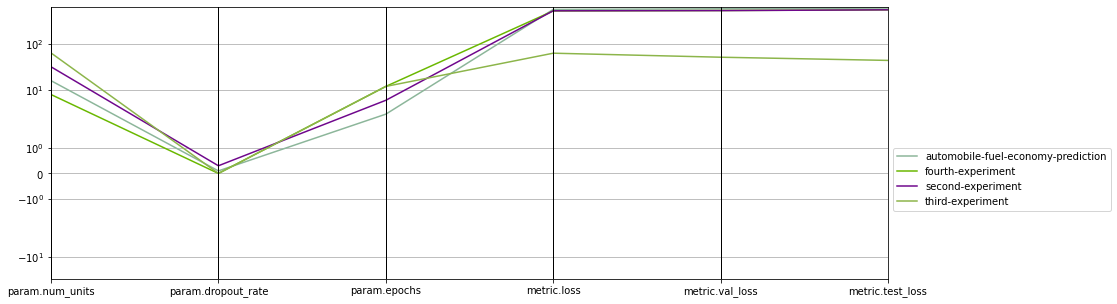

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 5]

ax = pd.plotting.parallel_coordinates(
    experiments_pivot.reset_index(level=0),
    'experiment_name', cols=['param.num_units', 'param.dropout_rate',
                             'param.epochs', 'metric.loss',
                             'metric.val_loss', 'metric.test_loss'],
    # color=['blue', 'green', 'pink', 'red'],
    )
ax.set_yscale('symlog')
ax.legend(bbox_to_anchor=(1.0, 0.5))